In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from feature_engine.outliers import Winsorizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
df = pd.read_csv('milk.csv')
df.head()

,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour,Grade
0,6.6,35,Good,Bad,High,Low,254.0,high
1,6.6,36,Bad,Good,Low,High,253.0,high
2,8.5,70,Good,Good,High,High,246.0,low
3,9.5,34,Good,Good,Low,High,255.0,low
4,6.6,37,Bad,Bad,Low,Low,255.0,medium


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1059 entries, 0 to 1058
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pH          1042 non-null   float64
 1   Temprature  1059 non-null   int64  
 2   Taste       1032 non-null   object 
 3   Odor        1059 non-null   object 
 4   Fat         1059 non-null   object 
 5   Turbidity   1059 non-null   object 
 6   Colour      1033 non-null   float64
 7   Grade       1059 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 66.3+ KB


In [4]:
df.isnull().sum()

pH            17
Temprature     0
Taste         27
Odor           0
Fat            0
Turbidity      0
Colour        26
Grade          0
dtype: int64

In [5]:
df.describe()

,pH,Temprature,Colour
count,1042.000000,1059.000000,1033.000000
mean,6.625624,44.226629,251.820910
std,1.401326,10.098364,4.321152
min,3.000000,34.000000,240.000000
25%,6.500000,38.000000,250.000000
50%,6.700000,41.000000,255.000000
75%,6.800000,45.000000,255.000000
max,9.500000,90.000000,255.000000


In [6]:
cat_col = df.select_dtypes(include=['object']).columns.tolist()

for i in cat_col:
    print(i)
    print(df[i].value_counts())
    print('-'*30)

Taste
Good    564
Bad     468
Name: Taste, dtype: int64
------------------------------
Odor
Bad     601
Good    458
Name: Odor, dtype: int64
------------------------------
Fat 
High    711
Low     348
Name: Fat , dtype: int64
------------------------------
Turbidity
Low     539
High    520
Name: Turbidity, dtype: int64
------------------------------
Grade
low       429
medium    374
high      256
Name: Grade, dtype: int64
------------------------------


## **Data Cleaning**

In [7]:
# rename column
df.rename({'Fat ': 'Fat'}, axis=1, inplace=True)

In [8]:
df.columns

Index(['pH', 'Temprature', 'Taste', 'Odor', 'Fat', 'Turbidity', 'Colour',
       'Grade'],
      dtype='object')

In [9]:
# target encoding
df.Grade.value_counts()

low       429
medium    374
high      256
Name: Grade, dtype: int64

In [10]:
df.Grade.replace({'low': 0, 'medium': 1, 'high': 2}, inplace=True)
df.Grade.value_counts()

0    429
1    374
2    256
Name: Grade, dtype: int64

In [11]:
# split
X = df.drop('Grade', axis=1)
y = df.Grade

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

for i in [X_train, X_test, y_train, y_test]:
    print(i.shape)

(741, 7)
(318, 7)
(741,)
(318,)


In [12]:
df_eda = pd.concat([X_train, y_train], axis=1)
df_eda.shape

(741, 8)

In [13]:
X_train_eda = X_train.copy()

## **EDA for Modeling**

In [14]:
df_eda.head()

,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour,Grade
143,3.0,40,Good,Bad,Low,Low,255.0,0
576,6.6,40,Good,Bad,High,High,255.0,2
686,3.0,40,Good,Good,High,High,255.0,0
544,6.5,37,Bad,Bad,Low,Low,255.0,1
889,6.8,45,Good,Good,High,High,245.0,2


In [15]:
num_col = ['pH', 'Temprature', 'Colour']
cat_col = ['Taste', 'Odor', 'Fat', 'Turbidity']

**numerical preprocess**

In [16]:
df[num_col]

,pH,Temprature,Colour
0,6.6,35,254.0
1,6.6,36,253.0
2,8.5,70,246.0
3,9.5,34,255.0
4,6.6,37,255.0
...,...,...,...
1054,6.7,45,247.0
1055,6.7,38,255.0
1056,3.0,40,255.0
1057,6.8,43,250.0


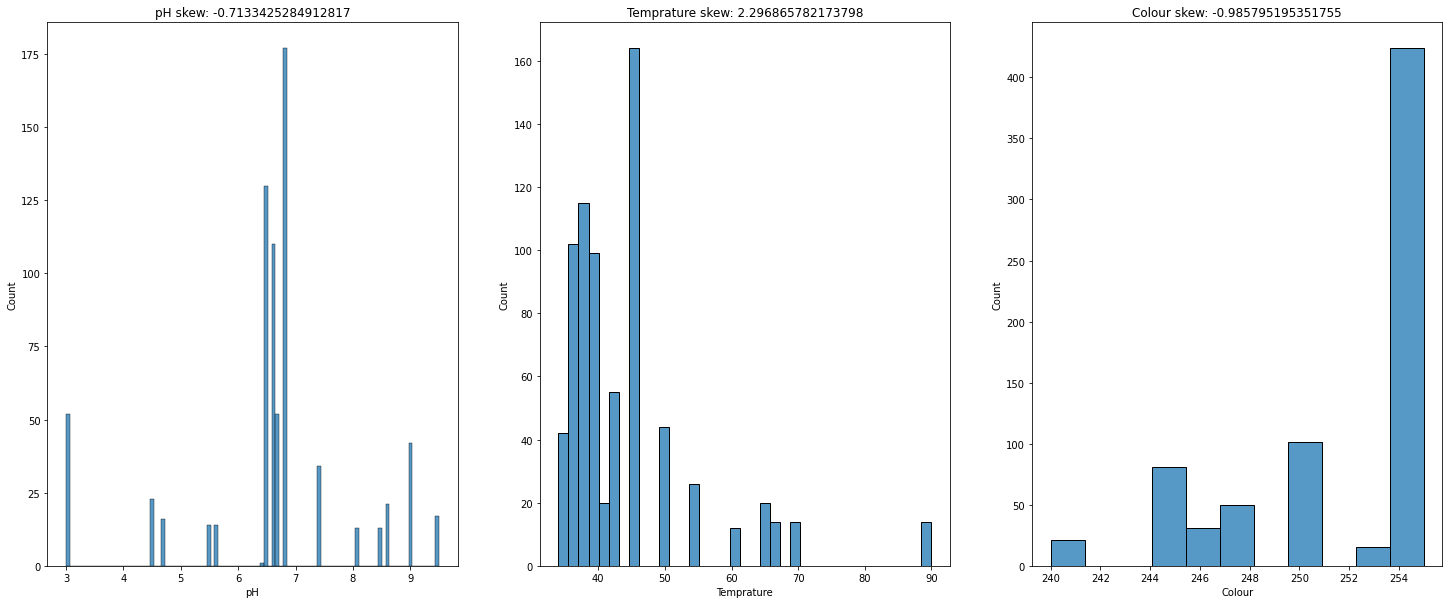

In [17]:
fig, ax = plt.subplots(ncols=3, figsize=[25,10])
ax = ax.flatten()

for idx, col in enumerate(num_col):
    sns.histplot(df_eda[col], ax=ax[idx])
    ax[idx].set_title(f'{num_col[idx]} skew: {df_eda[col].skew()}')

In [18]:
# outlier detection in pH
# gaussian
upper = df_eda['pH'].mean() + (3*df['pH'].std())
lower = df_eda['pH'].mean() - (3*df['pH'].std())

outlier = df_eda[(df_eda['pH'] <= lower) | (df_eda['pH'] >= upper)]

print('percentage: ', len(outlier)/df.shape[0] * 100, '%')

percentage:  0.0 %


In [19]:
# outlier detection in Temperature
Q1 = df_eda['Temprature'].quantile(.25)
Q3 = df_eda['Temprature'].quantile(.75)

IQR = Q3 - Q1

upper = Q3 + (3*IQR)
lower = Q1 - (3*IQR)

outlier = df_eda[(df_eda['Temprature'] <= lower) | (df_eda['Temprature'] >= upper)]

print('percentage: ', len(outlier)/df.shape[0] * 100, '%')
print('upper: ', upper)
print('lower: ', lower)

percentage:  3.9660056657223794 %
upper:  66.0
lower:  17.0


In [20]:
# outlier detection in Colour
Q1 = df_eda['Colour'].quantile(.25)
Q3 = df_eda['Colour'].quantile(.75)

IQR = Q3 - Q1

upper = Q3 + (3*IQR)
lower = Q1 - (3*IQR)

outlier = df_eda[(df_eda['Colour'] <= lower) | (df_eda['Colour'] >= upper)]

print('percentage: ', len(outlier)/df.shape[0] * 100, '%')

percentage:  0.0 %


outlier only exist in Temprature columns, using fold 3 IQR. will be handled using winsorizer transformer

In [21]:
wins = Winsorizer(capping_method='iqr', tail='both', fold=3, variables=['Temprature'])

X_train_eda = wins.fit_transform(X_train_eda)
X_train_eda.describe()

,pH,Temprature,Colour
count,729.000000,741.000000,723.000000
mean,6.593964,43.847503,251.788382
std,1.406321,8.431742,4.309466
min,3.000000,34.000000,240.000000
25%,6.500000,38.000000,248.000000
50%,6.700000,41.000000,255.000000
75%,6.800000,45.000000,255.000000
max,9.500000,66.000000,255.000000


**missing value handling**

In [22]:
X_train_eda[num_col].isnull().sum()

pH            12
Temprature     0
Colour        18
dtype: int64

missing value on numerical columns will be handled using median estimator from each columns

In [23]:
imp_num = SimpleImputer(strategy='median')

X_train_eda[num_col] = imp_num.fit_transform(X_train_eda[num_col])
X_train_eda[num_col].isnull().sum()

pH            0
Temprature    0
Colour        0
dtype: int64

In [24]:
imp_num.statistics_

array([  6.7,  41. , 255. ])

In [25]:
X_train_eda.describe()

,pH,Temprature,Colour
count,741.000000,741.000000,741.000000
mean,6.595682,43.847503,251.866397
std,1.394936,8.431742,4.285389
min,3.000000,34.000000,240.000000
25%,6.500000,38.000000,250.000000
50%,6.700000,41.000000,255.000000
75%,6.800000,45.000000,255.000000
max,9.500000,66.000000,255.000000


**scaling features numeric**

In [26]:
scaler = StandardScaler()

X_train_eda[num_col] = scaler.fit_transform(X_train_eda[num_col])
X_train_eda

,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour
143,-2.579409,-0.456620,Good,Bad,Low,Low,0.731724
576,0.003098,-0.456620,Good,Bad,High,High,0.731724
686,-2.579409,-0.456620,Good,Good,High,High,0.731724
544,-0.068638,-0.812659,Bad,Bad,Low,Low,0.731724
889,0.146571,0.136778,Good,Good,High,High,-1.603363
...,...,...,...,...,...,...,...
440,0.003098,0.136778,Bad,Bad,Low,High,-0.435820
840,-0.068638,-0.931338,Bad,Bad,High,Low,0.731724
429,0.074834,-0.693979,Good,Bad,High,Low,0.731724
462,-0.786001,0.136778,Good,Bad,High,High,-0.435820


**features engineering on categorical column**

In [27]:
X_train_eda.isnull().sum()

pH             0
Temprature     0
Taste         18
Odor           0
Fat            0
Turbidity      0
Colour         0
dtype: int64

In [28]:
# missing value handling
imp_cat = SimpleImputer(strategy='most_frequent')
X_train_eda[cat_col] = imp_cat.fit_transform(X_train_eda[cat_col])

imp_cat.statistics_

array(['Good', 'Bad', 'High', 'Low'], dtype=object)

In [29]:
X_train_eda.isnull().sum()

pH            0
Temprature    0
Taste         0
Odor          0
Fat           0
Turbidity     0
Colour        0
dtype: int64

In [30]:
X_train_eda[['Taste', 'Odor', 'Fat']]

,Taste,Odor,Fat
143,Good,Bad,Low
576,Good,Bad,High
686,Good,Good,High
544,Bad,Bad,Low
889,Good,Good,High
...,...,...,...
440,Bad,Bad,Low
840,Bad,Bad,High
429,Good,Bad,High
462,Good,Bad,High


In [31]:
# encoding Taste, Odor, Fat -> ordinal
taste_cat = ['Bad', 'Good']
odor_cat = ['Bad', 'Good']
fat_cat = ['Low', 'High']

ord_enc = OrdinalEncoder(categories=[taste_cat, odor_cat, fat_cat])
cat_ord = pd.DataFrame(ord_enc.fit_transform(X_train_eda[['Taste', 'Odor', 'Fat']]))

cat_ord.columns = ['Taste_enc', 'Odor_enc', 'Fat_enc']
review = pd.concat([X_train_eda[['Taste', 'Odor', 'Fat']].reset_index(drop=True), cat_ord], axis=1)

review.sample(5)

,Taste,Odor,Fat,Taste_enc,Odor_enc,Fat_enc
718,Bad,Bad,Low,0.0,0.0,0.0
671,Bad,Bad,Low,0.0,0.0,0.0
547,Good,Bad,High,1.0,0.0,1.0
474,Good,Good,High,1.0,1.0,1.0
207,Bad,Bad,Low,0.0,0.0,0.0


In [32]:
# OHE on Turbidity
ohe_enc = OneHotEncoder(sparse=False)

cat_ohe = pd.DataFrame(ohe_enc.fit_transform(X_train_eda[['Turbidity']]))
cat_ohe.columns = ohe_enc.get_feature_names(['Turbidity']).tolist()

review = pd.concat([X_train_eda[['Turbidity']].reset_index(drop=True), cat_ohe], axis=1)

review.sample(5)

,Turbidity,Turbidity_High,Turbidity_Low
280,High,1.0,0.0
596,High,1.0,0.0
399,Low,0.0,1.0
684,High,1.0,0.0
583,High,1.0,0.0


In [33]:
y_train

143     0
576     2
686     0
544     1
889     2
       ..
440     1
840     1
429     2
462     0
1008    0
Name: Grade, Length: 741, dtype: int64

In [34]:
X_train_eda = pd.concat([X_train_eda[num_col].reset_index(drop=True), cat_ord, cat_ohe, y_train.reset_index(drop=True)], axis=1)
X_train_eda.shape

(741, 9)

In [35]:
X_train_eda.head()

,pH,Temprature,Colour,Taste_enc,Odor_enc,Fat_enc,Turbidity_High,Turbidity_Low,Grade
0,-2.579409,-0.456620,0.731724,1.0,0.0,0.0,0.0,1.0,0
1,0.003098,-0.456620,0.731724,1.0,0.0,1.0,1.0,0.0,2
2,-2.579409,-0.456620,0.731724,1.0,1.0,1.0,1.0,0.0,0
3,-0.068638,-0.812659,0.731724,0.0,0.0,0.0,0.0,1.0,1
4,0.146571,0.136778,-1.603363,1.0,1.0,1.0,1.0,0.0,2


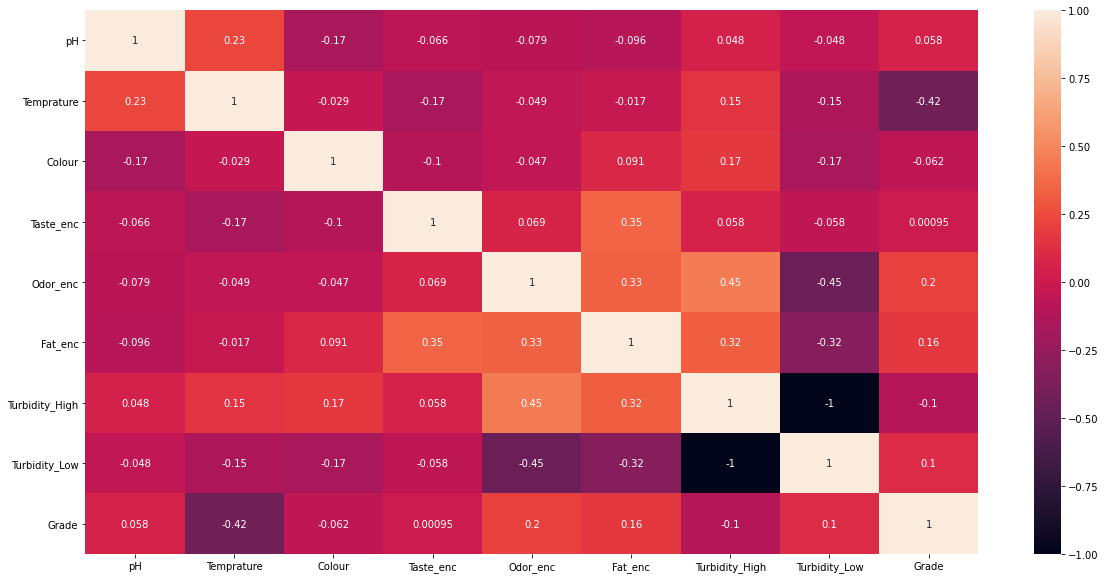

In [36]:
fig,ax = plt.subplots(figsize=[20,10])

corr = X_train_eda.corr()

ax = sns.heatmap(corr,annot=True)
plt.show()

Select Temprature, Odor_enc, Fat_enc, TUrbidity

Overall what we did to train data preprocess:
- For Numeric:
1. Outlier Handling
2. Missing value imputer using median
3. Scaling using Standard Scaler

- For categoric:
1. Missing value handling
2. ordinal encoding for Taste, Odor and Fat
3. OHE for Turbidity

## **Preprocess**

In [37]:
X_train['Temprature']

143     40
576     40
686     40
544     37
889     45
        ..
440     45
840     36
429     38
462     45
1008    40
Name: Temprature, Length: 741, dtype: int64

In [38]:
num_pipeline = Pipeline([
        ('outlier', Winsorizer(capping_method='iqr', tail='both', fold=3)),
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

num_tr = num_pipeline.fit_transform(X_train[['Temprature']])
num_tr

array([[-0.45661999],
       [-0.45661999],
       [-0.45661999],
       [-0.81265866],
       [ 0.13677779],
       [ 2.62904845],
       [-0.6939791 ],
       [-0.45661999],
       [-0.93133821],
       [ 2.62904845],
       [-0.93133821],
       [ 0.13677779],
       [ 0.13677779],
       [ 0.13677779],
       [-0.45661999],
       [-0.45661999],
       [ 2.62904845],
       [-0.81265866],
       [-0.10058132],
       [ 0.13677779],
       [-0.6939791 ],
       [-0.6939791 ],
       [ 0.13677779],
       [-0.81265866],
       [ 0.73017556],
       [-0.93133821],
       [-0.45661999],
       [-0.45661999],
       [-0.10058132],
       [-0.93133821],
       [ 1.32357334],
       [ 0.73017556],
       [ 1.32357334],
       [-0.93133821],
       [-0.6939791 ],
       [-1.16869732],
       [ 0.13677779],
       [ 0.13677779],
       [ 2.62904845],
       [-1.16869732],
       [-0.81265866],
       [ 0.13677779],
       [ 1.32357334],
       [ 0.13677779],
       [ 2.5103689 ],
       [-0

In [39]:
cat_1_pipeline = Pipeline([
        ('imputer_1', SimpleImputer(strategy='most_frequent')),
        ('ordinal_enc', OrdinalEncoder(categories=[['Bad', 'Good'], ['Low', 'High']])) #odor & fat
    ])

cat_1_tr = cat_1_pipeline.fit_transform(X_train[['Odor', 'Fat']])
cat_1_tr

array([[0., 0.],
       [0., 1.],
       [1., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 1.]])

In [40]:
cat_2_pipeline = Pipeline([
        ('imputer_2', SimpleImputer(strategy='most_frequent')),
        ('ohe_enc', OneHotEncoder(sparse=False)) #odor & fat
    ])

cat_2_tr = cat_2_pipeline.fit_transform(X_train[['Turbidity']])
cat_2_tr

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]])

In [41]:
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, ['Temprature']),
        ("cat_ord", cat_1_pipeline, ['Odor', 'Fat']),
        ("cat_ohe", cat_2_pipeline, ['Turbidity']),
    ])

train_tr = full_pipeline.fit_transform(X_train)
train_tr

array([[-0.45661999,  0.        ,  0.        ,  0.        ,  1.        ],
       [-0.45661999,  0.        ,  1.        ,  1.        ,  0.        ],
       [-0.45661999,  1.        ,  1.        ,  1.        ,  0.        ],
       ...,
       [-0.6939791 ,  0.        ,  1.        ,  0.        ,  1.        ],
       [ 0.13677779,  0.        ,  1.        ,  1.        ,  0.        ],
       [-0.45661999,  1.        ,  1.        ,  1.        ,  0.        ]])

In [42]:
train_manual = np.array(X_train_eda[['Temprature', 'Odor_enc', 'Fat_enc', 'Turbidity_High', 'Turbidity_Low']])

np.allclose(train_tr, train_manual)

True

In [43]:
test_tr = full_pipeline.transform(X_test)
test_tr

array([[-0.6939791 ,  0.        ,  1.        ,  0.        ,  1.        ],
       [-0.6939791 ,  0.        ,  0.        ,  0.        ,  1.        ],
       [-0.93133821,  0.        ,  1.        ,  0.        ,  1.        ],
       ...,
       [-0.93133821,  0.        ,  0.        ,  0.        ,  1.        ],
       [-0.6939791 ,  0.        ,  1.        ,  0.        ,  1.        ],
       [-0.45661999,  0.        ,  0.        ,  0.        ,  1.        ]])

## **Modeling**

In this section we will compare the performance between 4 models:
- LogisticReg
- SVC
- DecisionTree Classifier
- RandomFOrest Classifier

In [44]:
logreg = LogisticRegression(random_state=0)
svc = SVC(random_state=0)
dtc = DecisionTreeClassifier(random_state=0)
rfc = RandomForestClassifier(random_state=0)

In [45]:
logreg.fit(train_tr, y_train)

lr_train = logreg.predict(train_tr)
lr_test = logreg.predict(test_tr)

print(classification_report(y_train, lr_train))
print(classification_report(y_test, lr_test))

              precision    recall  f1-score   support

           0       0.66      0.59      0.62       300
           1       0.72      0.84      0.78       262
           2       0.50      0.47      0.49       179

    accuracy                           0.65       741
   macro avg       0.63      0.63      0.63       741
weighted avg       0.64      0.65      0.64       741

              precision    recall  f1-score   support

           0       0.75      0.66      0.70       129
           1       0.72      0.93      0.81       112
           2       0.48      0.38      0.42        77

    accuracy                           0.69       318
   macro avg       0.65      0.65      0.65       318
weighted avg       0.67      0.69      0.67       318



In [46]:
svc.fit(train_tr, y_train)

svc_train = svc.predict(train_tr)
svc_test = svc.predict(test_tr)

print(classification_report(y_train, svc_train))
print(classification_report(y_test, svc_test))

              precision    recall  f1-score   support

           0       0.97      0.67      0.79       300
           1       0.80      0.94      0.87       262
           2       0.63      0.79      0.70       179

    accuracy                           0.80       741
   macro avg       0.80      0.80      0.79       741
weighted avg       0.83      0.80      0.80       741

              precision    recall  f1-score   support

           0       0.96      0.73      0.83       129
           1       0.77      0.96      0.86       112
           2       0.61      0.64      0.62        77

    accuracy                           0.79       318
   macro avg       0.78      0.78      0.77       318
weighted avg       0.81      0.79      0.79       318



In [47]:
dtc.fit(train_tr, y_train)

dtc_train = dtc.predict(train_tr)
dtc_test = dtc.predict(test_tr)

print(classification_report(y_train, dtc_train))
print(classification_report(y_test, dtc_test))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       300
           1       0.85      0.98      0.91       262
           2       0.91      0.72      0.80       179

    accuracy                           0.89       741
   macro avg       0.89      0.87      0.87       741
weighted avg       0.89      0.89      0.88       741

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       129
           1       0.81      0.97      0.89       112
           2       0.84      0.64      0.73        77

    accuracy                           0.86       318
   macro avg       0.86      0.84      0.84       318
weighted avg       0.86      0.86      0.86       318



In [48]:
rfc.fit(train_tr, y_train)

rfc_train = rfc.predict(train_tr)
rfc_test = rfc.predict(test_tr)

print(classification_report(y_train, rfc_train))
print(classification_report(y_test, rfc_test))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       300
           1       0.85      0.98      0.91       262
           2       0.91      0.72      0.80       179

    accuracy                           0.89       741
   macro avg       0.89      0.87      0.87       741
weighted avg       0.89      0.89      0.88       741

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       129
           1       0.81      0.97      0.89       112
           2       0.84      0.64      0.73        77

    accuracy                           0.86       318
   macro avg       0.86      0.84      0.84       318
weighted avg       0.86      0.86      0.86       318



In [73]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rfc, train_tr, y_train,
                         scoring="accuracy", cv=10)

scores.std()

0.01596084202690877

**Hyper-param Tuning**

In [ ]:
params = [
    {'n_estimators': [10, 20, 40, 60],        # 4
     'max_features': [2, 3, 5, 1],            # 4
     'max_depth': [5, 10, None],              # 3
     'criterion': ['gini', 'entropy']},       # 2   Total 4*4*3*2 = 96 combinations
  ]

rfc = RandomForestClassifier(random_state=0)

grid_search = GridSearchCV(rfc, params, cv=5,
                           scoring='accuracy',
                           return_train_score=True)
grid_search.fit(train_tr, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': [5, 10, None],
                          'max_features': [2, 3, 5, 1],
                          'n_estimators': [10, 20, 40, 60]}],
             return_train_score=True, scoring='accuracy')

In [ ]:
pd.DataFrame(grid_search.cv_results_).shape

(96, 24)

In [ ]:
grid_search.best_params_

{'criterion': 'gini', 'max_depth': 10, 'max_features': 3, 'n_estimators': 60}

In [ ]:
grid_search.best_score_

0.865055323780156

In [ ]:
model = grid_search.best_estimator_

model.fit(train_tr, y_train)

model_train = model.predict(train_tr)
model_test = model.predict(test_tr)

print(classification_report(y_train, model_train))
print(classification_report(y_test, model_test))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       300
           1       0.85      0.98      0.91       262
           2       0.91      0.72      0.80       179

    accuracy                           0.89       741
   macro avg       0.89      0.87      0.87       741
weighted avg       0.89      0.89      0.88       741

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       129
           1       0.81      0.97      0.89       112
           2       0.84      0.64      0.73        77

    accuracy                           0.86       318
   macro avg       0.86      0.84      0.84       318
weighted avg       0.86      0.86      0.86       318



**combine pipeline: preprocess + model**

In [ ]:
full_pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('outlier',
                                                  Winsorizer(capping_method='iqr',
                                                             tail='both')),
                                                 ('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Temprature']),
                                ('cat_ord',
                                 Pipeline(steps=[('imputer_1',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinal_enc',
                                                  OrdinalEncoder(categories=[['Bad',
                                                                              'Good'],
                           

In [ ]:
all_process = Pipeline([
    ("preprocess", full_pipeline),
    ("classification", model)
])

all_process.fit(X_train, y_train)
hasil = all_process.predict(X_test)

print(classification_report(y_test, hasil))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       129
           1       0.81      0.97      0.89       112
           2       0.84      0.64      0.73        77

    accuracy                           0.86       318
   macro avg       0.86      0.84      0.84       318
weighted avg       0.86      0.86      0.86       318

